In [ ]:
from OptimalHedging.GBM import GBMSimulator
from OptimalHedging.Heston import HestonSimulator
from OptimalHedging.JumpDiff import JumpDiffusionSimulator

In [56]:
from OptimalHedging.Simulator import BaseSimulator
import numpy as np
from numpy.polynomial.chebyshev import Chebyshev
from typing import Dict, List, Tuple
import OptimalHedging.tools as tools


class GBMSimulator(BaseSimulator):
    """
    Simulator for Geometric Brownian Motion (GBM) + optimal hedging machinery.
    """

    def __init__(self, 
                 **base_kwargs):
        """
        Initialize the GBM simulator.

        This class does not introduce new parameters and simply forwards
        all arguments to the BaseSimulator initializer.
        """
        super().__init__(**base_kwargs)

    # ============================================================
    # 0. Underlying S and derivative H (your original code)
    # ============================================================

    def simulate_S(self) -> np.ndarray:
        """
        Simulate Geometric Brownian Motion (GBM) paths using a fully vectorized Euler–Maruyama scheme.

            dS = mu * S * dt + sigma * S * dW

        Returns
        -------
        S : ndarray, shape (M, steps)
            Simulated GBM underlying asset price paths.
        """
        dW = np.random.normal(loc=0.0,
                              scale=np.sqrt(self.dt),
                              size=(self.M, self.steps - 1))    # (M, steps-1)

        # multiplicative Euler step: S_{n+1} = S_n * (1 + mu*dt + sigma*dW)
        factors = 1 + self.mu * self.dt + self.sigma * dW
        factors = np.hstack((np.ones((self.M, 1)), factors))    # insert initial factor = 1
        S = self.S0 * np.cumprod(factors, axis=1)               # (M, steps)
        
        self.S_GBM = S
        self.dW_GBM = dW

        return S

    def simulate_H(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Estimate H(t,S) = E[(S_T - K)^+ | S_t = S] and derivatives using a single-pass 
        LSMC (least-squares Monte Carlo) regression on the already-simulated paths.

        Approach
        --------
        - Regress payoff Y = (S_T - K)^+ on a tensor Chebyshev basis in (t, x), where x = log(S) using ridge regularization.
        - Compute derivatives analytically from the fitted basis in (t, x).
        - Convert x-derivatives to S-derivatives via chain rule.

        Returns
        -------
        H : ndarray, shape (M, steps)
            Simulated contigent claim price path.
        dH_dS : ndarray, shape (M, steps)
            First-order derivative against underlying asset.
        d2H_dSS : ndarray, shape (M, steps)
            Second-order derivative against underlying asset. 
        dH_dt : ndarray, shape (M, steps)
            First-order derivative against time-step.
        d2H_dt_dS : ndarray, shape (M, steps)
            Second-order derivative against time-step and underlying asset.
        d3H_dS3 : ndarray, shape (M, steps)
            Third-order derivative against underlying asset.
        """

        if getattr(self, "S_GBM", None) is None:
            raise ValueError("self.S_GBM is None. Run simulate_S() first.")

        # ----------------------------
        # Hyperparameters (tunable)
        # ----------------------------
        p_t = 1              # Chebyshev degree in time
        p_x = 2              # Chebyshev degree in x = log(S)
        lam_ridge = 1e-2     # ridge regularization (increase if derivatives are noisy)

        # ----------------------------
        # 1) Targets and state
        # ----------------------------
        # payoff per path (same target used across all times for that path)
        Y = np.maximum(self.S_GBM[:, -1] - self.K, 0.0) 

        # x = log(S) (work in x for numerical stability)
        X_path = np.log(np.maximum(self.S_GBM, 1e-300))                             # (M, self.steps)

        # time grid
        t_grid = self.t0 + self.dt * np.arange(self.steps)                          # (self.steps, )

        # ----------------------------
        # 2) Scale (t, x) to [-1, 1]
        # ----------------------------
        x_min = float(X_path.min())
        x_max = float(X_path.max())
        if not np.isfinite(x_min) or not np.isfinite(x_max) or x_max <= x_min:
            raise ValueError("Invalid X_path range for scaling.")

        zt = tools._minmax_scale(t_grid, self.t0, self.T)                           # (self.steps, )
        zx = tools._minmax_scale(X_path.reshape(-1), x_min, x_max)                  # (M*self.steps, )

        # scaling factors for derivatives:
        # z = a*u + b => dz/du = a
        dz_dt = 2.0 / (self.T - self.t0)
        dz_dx = 2.0 / (x_max - x_min)

        # ----------------------------
        # 3) Chebyshev basis and derivatives in (t, zt) and (x, zx)
        # ----------------------------
        # time basis: (N_time, p_t+1)
        Tt = tools._cheb_eval_all(zt, p_t, deriv=0)
        dTt_dz = tools._cheb_eval_all(zt, p_t, deriv=1)
        dTt_dt = dTt_dz * dz_dt                                                    # chain rule

        # x basis on all observations (flattened): (M*N_time, p_x+1)
        Tx = tools._cheb_eval_all(zx, p_x, deriv=0)
        dTx_dz = tools._cheb_eval_all(zx, p_x, deriv=1)
        d2Tx_dz2 = tools._cheb_eval_all(zx, p_x, deriv=2)
        d3Tx_dz3 = tools._cheb_eval_all(zx, p_x, deriv=3)

        # convert z-derivatives to x-derivatives (x = log S):
        dTx_dx   = dTx_dz   * (dz_dx)
        d2Tx_dx2 = d2Tx_dz2 * (dz_dx ** 2)
        d3Tx_dx3 = d3Tx_dz3 * (dz_dx ** 3)

        # ----------------------------
        # 4) Build design matrix Phi for tensor basis in (t, x)
        #    Phi row corresponds to one observation (m,n).
        # ----------------------------
        N_obs = self.M * self.steps
        P = (p_t + 1) * (p_x + 1)
        Phi = np.empty((N_obs, P), dtype=float)

        # Repeat time basis rows M times to align with flattened X_path ordering
        # Flatten convention used above: X_path.reshape(-1) is row-major -> time index changes fastest.
        # That means order is: (m=0,n=0..), (m=1,n=0..), ...
        # So time basis for each m is the same t_grid, repeated per path.
        col = 0
        for i in range(p_t + 1):
            tt_rep = np.tile(Tt[:, i], self.M)                                  # (N_obs, )
            for j in range(p_x + 1):
                Phi[:, col] = tt_rep * Tx[:, j]
                col += 1

        # Targets replicated per time within each path:
        y = np.repeat(Y, self.steps)                                            # (N_obs, )

        # ----------------------------
        # 5) Fit ridge regression
        # ----------------------------
        beta = tools._ridge_solve(Phi, y, lam=lam_ridge)                        # (P, )

        # reshape coefficients into (p_t+1, p_x+1) for clearer evaluation
        B = beta.reshape(p_t + 1, p_x + 1)

        # ----------------------------
        # 6) Evaluate H and derivatives in (t, x)
        # ----------------------------
        # We evaluate on the same observation grid (m,n) using flattened arrays for x-basis,
        # then reshape back to (M, N_time).
        H_flat    = np.zeros(N_obs, dtype=float)
        Ht_flat   = np.zeros(N_obs, dtype=float)
        Hx_flat   = np.zeros(N_obs, dtype=float)
        Hxx_flat  = np.zeros(N_obs, dtype=float)
        Hxxx_flat = np.zeros(N_obs, dtype=float)
        Htx_flat  = np.zeros(N_obs, dtype=float)

        for i in range(p_t + 1):
            tt0 = np.tile(Tt[:, i], self.M)                                      # (N_obs, )
            tt1 = np.tile(dTt_dt[:, i], self.M)                                  # (N_obs, )
            for j in range(p_x + 1):
                Bij = B[i, j]
                if Bij == 0.0:
                    continue
                base = tt0 * Tx[:, j]
                H_flat += Bij * base

                # time derivative
                Ht_flat += Bij * (tt1 * Tx[:, j])

                # x-derivatives
                Hx_flat   += Bij * (tt0 * dTx_dx[:, j])
                Hxx_flat  += Bij * (tt0 * d2Tx_dx2[:, j])
                Hxxx_flat += Bij * (tt0 * d3Tx_dx3[:, j])

                # mixed derivative (t,x)
                Htx_flat  += Bij * (tt1 * dTx_dx[:, j])

        H = H_flat.reshape(self.M, self.steps)
        H = np.maximum(H, 0)
        H_t = Ht_flat.reshape(self.M, self.steps)
        H_x = Hx_flat.reshape(self.M, self.steps)
        H_xx = Hxx_flat.reshape(self.M, self.steps)
        H_xxx = Hxxx_flat.reshape(self.M, self.steps)
        H_tx = Htx_flat.reshape(self.M, self.steps)

        # ----------------------------
        # 7) Convert x=log(S) derivatives to S-derivatives
        # ----------------------------
        S = np.maximum(self.S_GBM, 1e-300)
        dH_dS = (1.0 / S) * H_x
        d2H_dSS = (1.0 / (S ** 2)) * (H_xx - H_x)
        d3H_dS3 = (1.0 / (S ** 3)) * (H_xxx - 3.0 * H_xx + 2.0 * H_x)
        dH_dt = H_t
        d2H_dtdS = (1.0 / S) * H_tx

        # ----------------------------
        # 8) Store 
        # ----------------------------
        self.H_GBM = H
        self.dH_dS_GBM = dH_dS
        self.d2H_dSS_GBM = d2H_dSS
        self.dH_dt_GBM = dH_dt
        self.d2H_dtdS_GBM = d2H_dtdS
        self.d3H_dS3_GBM = d3H_dS3

        # Keep regression metadata if useful for debugging/reuse
        self._H_fit_GBM = {
            "p_t": p_t,
            "p_x": p_x,
            "lam_ridge": lam_ridge,
            "x_min": x_min,
            "x_max": x_max,
            "beta": beta,
        }

        return H, dH_dS, d2H_dSS, dH_dt, d2H_dtdS, d3H_dS3
    
    def init_control(self, kind: str = "Delta") -> np.ndarray:
        """
        Initialize the control h.

        Parameters
        ----------
        kind : {"Delta", "zero"}
            Initialization rule.

        Returns
        -------
        h : ndarray, shape (M, steps-1)
            Initial control on each time interval [t_n, t_{n+1}).
        """
        if kind == "Delta":
            h0 = 0.7 * self.dH_dS_GBM[:, :-1].copy()                            # smooth initial guess
        elif kind == "zero":
            h0 = np.zeros((self.M, self.steps - 1))
        else:
            raise ValueError("Unknown control initialization kind")

        return h0

    # ============================================================
    # 2. Forward P&L
    # ============================================================
    
    def forward_PL(self, h: np.ndarray, L0: float = 0.0) -> np.ndarray:
        """
        Vectorized Profit and Loss L_t using portfolio value:

            V_t^h = h_t S_t - H_t
            Delta L_n = V_{n+1}^h - V_n^h
                      = h_n (S_{n+1} - S_n) - (H_{n+1} - H_n)

        Parameters
        ----------
        h : ndarray, shape (M, steps-1)
            Hedge ratio on each interval [t_n, t_{n+1}).
        L0 : float, default=0.0
            Initial P&L (relative).

        Returns
        -------
        L : ndarray, shape (M, steps)
            Profit and Loss paths over time.
        """
        assert h.shape == (self.M, self.steps - 1)

        L = np.zeros((self.M, self.steps))
        L[:, 0] = L0

        # increments
        dS = np.diff(self.S_GBM, axis=1)         
        dH = np.diff(self.H_GBM, axis=1)          
        dL = h * dS - dH

        L = np.empty((self.M, self.steps), dtype=float)
        L[:, 0] = L0
        L[:, 1:] = L0 + np.cumsum(dL, axis=1)

        return L

    # ============================================================
    # 3. Risk functional rho_u(L_T)
    # ============================================================

    @staticmethod
    def risk_function(LT: np.ndarray, risk_type: str, **kwargs) -> float:
        """
        Compute the composed risk functional rho_u(L_T) from terminal Profit and Loss simulation.

        Parameters
        ----------
        LT : ndarray, shape (M,)
            Terminal Profit and Loss samples L_T^h generated by a given hedging strategy.
        risk_type : str
            Type of composed risk measure to be evaluated. Supported values are:
                - "ele"  : Expected loss with exponential utility
                - "elw"  : Expected loss with Weibull-type utility
                - "entl" : Entropic risk with linear utility
                - "ente" : Entropic risk with exponential utility
                - "entw" : Entropic risk with Weibull-type utility
                - "esl"   : Expected shortfall linear utility
        **kwargs :
            Parameters required by the chosen risk_type:
                - "a"     : risk aversion parameter (exponential utility)
                - "k"     : shape parameter (Weibull utility)
                - "gamma" : entropic risk aversion parameter
                - "beta"  : confidence level for expected shortfall

        Returns
        -------
        rho : float
            Estimation of the composed risk functional rho_u(L_T).
        """
        LT = np.asarray(LT)

        # ----------------------------
        # ele
        # ----------------------------
        if risk_type == "ele":
            a = kwargs.get("a")
            if a is None:
                raise ValueError("Parameter 'a' is required for 'ele'.")
            rho = np.mean(np.exp(-a * LT))

        # ----------------------------
        # elw
        # ----------------------------
        elif risk_type == "elw":
            k = kwargs.get("k")
            if k is None:
                raise ValueError("Parameter 'k' is required for 'elw'.")
            rho = np.mean(np.exp((-np.minimum(LT, 0.0))**k))

        # ----------------------------
        # entl
        # ----------------------------
        elif risk_type == "entl":
            gamma = kwargs.get("gamma")
            if gamma is None:
                raise ValueError("Parameter 'gamma' is required for 'entl'.")
            rho = (1.0 / gamma) * np.log(np.mean(np.exp(-gamma * LT)))

        # ----------------------------
        # ente
        # ----------------------------
        elif risk_type == "ente":
            gamma = kwargs.get("gamma")
            a = kwargs.get("a")
            if gamma is None or a is None:
                raise ValueError("Parameters 'gamma' and 'a' are required for 'ente'.")
            rho = (1.0 / gamma) * np.log(np.mean(np.exp(gamma * np.exp(-a * LT))))

        # ----------------------------
        # entw
        # ----------------------------
        elif risk_type == "entw":
            gamma = kwargs.get("gamma")
            k     = kwargs.get("k")
            if gamma is None or k is None:
                raise ValueError("Parameters 'gamma' and 'k' are required for risk_type='entw'.")
            rho = (1.0 / gamma) * np.log(np.mean(np.exp(gamma * np.exp((-np.minimum(LT, 0.0))**k)) ))

        # ----------------------------
        # esl
        # ----------------------------
        elif risk_type == "esl":
            beta = kwargs.get("beta")
            if beta is None:
                raise ValueError("Parameter 'beta' is required for risk_type='esl'.")
            LT = -LT
            alpha = np.quantile(LT, beta)
            rho = alpha + (1.0 / (1.0 - beta)) * np.mean(np.maximum(LT - alpha, 0.0))

        else:
            raise ValueError(f"Unknown risk_type '{risk_type}'.")

        return rho

    # ============================================================
    # 4. Terminal adjoint p_T = Upsilon(L_T)
    # ============================================================

    @staticmethod
    def terminal_adjoint(LT: np.ndarray, risk_type: str, **kwargs) -> np.ndarray:
        """
        Compute the terminal adjoint p_T = Upsilon(L_T) for the composed risk functional.

        Parameters
        ----------
        LT : ndarray, shape (M,)
            Terminal Profit and Loss samples L_T^h generated by a given hedging strategy.
        risk_type : str
            Type of composed risk measure. Supported values are:
                - "ele"  : Expected loss with exponential utility
                - "elw"  : Expected loss with Weibull-type utility
                - "entl" : Entropic risk with linear utility
                - "ente" : Entropic risk with exponential utility
                - "entw" : Entropic risk with Weibull-type utility
                - "esl"  : Expected shortfall with linear utility 
        **kwargs :
            Parameters required by the chosen risk_type:
                - "a"     : risk aversion parameter (exponential utility)
                - "k"     : shape parameter (Weibull utility)
                - "gamma" : entropic risk aversion parameter
                - "beta"  : confidence level for expected shortfall

        Returns
        -------
        pT : ndarray, shape (M,)
            Terminal adjoint samples p_T = Upsilon(L_T).
        """
        LT = np.asarray(LT)

        # ----------------------------
        # ele
        # ----------------------------
        if risk_type == "ele":
            a = kwargs.get("a")
            if a is None:
                raise ValueError("Parameter 'a' is required for 'ele'.")
            # Gamma(X) = -a e^{-a X}
            pT = -a * np.exp(-a * LT)

        # ----------------------------
        # elw
        # ----------------------------
        elif risk_type == "elw":
            k = kwargs.get("k")
            U = kwargs.get("U", 5.0)   
            if k is None:
                raise ValueError("Parameter 'k' is required for 'elw'.")
            u = np.minimum((-np.minimum(LT, 0.0))**k,U)
            pT = -k * (-np.minimum(LT, 0.0)) **(k - 1.0) * np.exp(u)

        # ----------------------------
        # entl
        # ----------------------------
        elif risk_type == "entl":
            gamma = kwargs.get("gamma")
            U = kwargs.get("U", 5.0)   
            if gamma is None:
                raise ValueError("Parameter 'gamma' is required for 'entl'.")
            u = np.clip(-gamma * LT, -U, U)
            pT = -np.exp(u) / np.mean(np.exp(u))

        # ----------------------------
        # ente
        # ----------------------------
        elif risk_type == "ente":
            gamma = kwargs.get("gamma")
            a = kwargs.get("a")
            U = kwargs.get("U", 5.0)   
            if gamma is None or a is None:
                raise ValueError("Parameters 'gamma' and 'a' are required for 'ente'.")
            u1 = np.clip(-a * LT, -U, U)
            u2 = np.minimum(gamma * np.exp(u1), U)
            pT = -a * np.exp(u1) * np.exp(u2)  / np.mean(np.exp(u2))

        # ----------------------------
        # entw
        # ----------------------------
        elif risk_type == "entw":
            gamma = kwargs.get("gamma")
            k = kwargs.get("k")
            U = kwargs.get("U", 5.0)
            if gamma is None or k is None:
                raise ValueError("Parameters 'gamma' and 'k' are required for risk_type='entw'.")
            u1 = np.minimum((-np.minimum(LT, 0.0) )**k, U)     
            u2 = np.minimum(gamma * np.exp(u1), U)  
            pT = -k * (-np.minimum(LT, 0.0))**(k - 1.0) * np.exp(u1) * np.exp(u2) / np.mean(np.exp(u2))

        # ----------------------------
        # esl
        # ----------------------------
        elif risk_type == "esl":
            beta = kwargs.get("beta")
            if beta is None:
                raise ValueError("Parameter 'beta' is required for risk_type='esl'.")
            # ES is applied to losses: X = -L_T
            LT = -LT
            alpha = np.quantile(LT, beta) 
            pT = (LT >= alpha).astype(float) / (1.0 - beta)

        else:
            raise ValueError(f"Unknown risk_type '{risk_type}'.")

        return pT


    # ============================================================
    # 5. Backward adjoint (p_t, q_t)
    # ============================================================
    def backward_adjoint(self,
                         pT: float,
                         p_x: int = 2,
                         lam_ridge: float = 1e-2,
                         lam_time: float = 1e-1) -> tuple[np.ndarray, np.ndarray]:
        """
        Backward adjoint BSDE solved step-by-step (one regression per time n),
        with:
        - regressor x = log(S)
        - Chebyshev basis of degree p_x
        - ridge regularization + intertemporal smoothing of coefficients
        """
        p = np.zeros((self.M, self.steps), dtype=float)
        q = np.zeros((self.M, self.steps - 1), dtype=float)
        p[:, -1] = pT

        # global regressor: x = log(S)
        S_all = np.maximum(self.S_GBM, 1e-300)
        X_all = np.log(S_all)

        x_min = float(X_all.min())
        x_max = float(X_all.max())
        if not np.isfinite(x_min) or not np.isfinite(x_max) or x_max <= x_min:
            raise ValueError("Invalid scaling range for log(S).")

        P = p_x + 1
        beta_p_next = np.zeros(P)
        beta_q_next = np.zeros(P)

        for n in range(self.steps - 2, -1, -1):
            Sn = self.S_GBM[:, n]
            dWn = self.dW_GBM[:, n]

            # drift coefficient A_n
            d2H_dtdS_n = self.d2H_dtdS_GBM[:, n]
            d2H_dSS_n  = self.d2H_dSS_GBM[:, n]
            d3H_dS3_n  = self.d3H_dS3_GBM[:, n]

            A_n = d2H_dtdS_n + 0.5 * (self.sigma**2) * (2.0 * Sn * d2H_dSS_n + (Sn**2) * d3H_dS3_n)

            p_next = p[:, n + 1]

            # regressors: phi(x_n)
            x_n = X_all[:, n]
            z = tools._minmax_scale(x_n, x_min, x_max)
            Phi = tools._cheb_eval_all(z, p_x, deriv=0)

            # q_n
            y_q = (p_next * dWn) / self.dt
            beta_q = tools._solve_smoothed(Phi, y_q, beta_q_next, lam_ridge, lam_time)
            q[:, n] = Phi @ beta_q

            # p_n
            y_p = p_next - A_n * p_next * dt
            beta_p = tools._solve_smoothed(Phi, y_p, beta_p_next, lam_ridge, lam_time)
            p[:, n] = Phi @ beta_p

            beta_q_next = beta_q
            beta_p_next = beta_p

        self.p_GBM = p
        self.q_GBM = q
        return p, q




    # ============================================================
    # 6. Optimality condition / gradient
    # ============================================================
    def compute_gradient(self, p: np.ndarray, q: np.ndarray) -> np.ndarray:
        """
        Compute the violation of the local optimality condition
        (e.g. G_n = μ S_n p_n + σ S_n q_n for GBM).

        Parameters
        ----------
        p : ndarray, shape (M, steps)
        q : ndarray, shape (M, steps-1)

        Returns
        -------
        G : ndarray, shape (M, steps-1)
            Gradient-like quantity used to update the control.
        """
        assert p.shape == (self.M, self.steps)
        assert q.shape == (self.M, self.steps - 1)

        S_trunc = self.S_GBM[:, :-1]
        G = self.mu * S_trunc * p[:, :-1] + self.sigma * S_trunc * q
        return G



    # ============================================================
    # 7. Control update
    # ============================================================

    def update_control(self,
                       h: np.ndarray,
                       G: np.ndarray,
                       alpha: float = 1,
                       eps: float = 1e-12) -> np.ndarray:
        """
        Update the control using G (e.g. a gradient step).

        Parameters
        ----------
        h : ndarray, shape (M, steps-1)
            Current control.
        G : ndarray, shape (M, steps-1)
            Gradient-like term.
        alpha : float
            Step size.
        eps : float, optional
            Small constant to avoid division by zero.

        Returns
        -------
        h_new : ndarray, shape (M, steps-1)
            Updated control.
        """
        assert h.shape == G.shape
        norm_G = np.linalg.norm(G) / np.sqrt(G.size) + eps
        G_normalized = G / norm_G
        h_new = h - alpha * G_normalized

        return h_new

        

    # ============================================================
    # 8. Main optimization loop
    # ============================================================
    def optimize_hedge(self,
                       risk_type: str,
                       risk_kwargs: Dict,
                       max_iter: int = 20,
                       tol: float = 1e-4,
                       alpha: float = 1e-3,
                       verbose: bool = True) -> Tuple[np.ndarray, List[Dict]]:
        """
        Main optimization loop to compute an approximate optimal hedge h.
        - Keep the last two accepted controls: h_curr (best/current), h_prev (previous).
        - At each iteration, compute grad_norm at h_curr.
        - If the first trial step from h_curr with current alpha does NOT improve grad_norm,
            rollback immediately to h_prev, shrink alpha, and search from there.
        - During the search, the anchor stays fixed; alpha is halved until improvement is found.
        - If improvement cannot be found (alpha too small), stop.

        Parameters
        ----------
        risk_type : str
            One of {"ele", "elw", "entl", "ente", "entw", "es"}.
        risk_kwargs : dict
            Parameters required for the chosen risk_type.
        max_iter : int
            Maximum number of iterations.
        tol : float
            Tolerance on E[G^2] (stopping criterion).
        alpha : float
            Step size for control updates.
        verbose : bool
            If True, print iteration logs.

        Returns
        -------
        h_opt : ndarray, shape (M, steps-1)
            Approximate optimal control.
        history : list of dict
            Iteration history (risk value, gradient norm, etc.).
        """
        h_curr = self.init_control(kind="Delta")
        h_prev = None

        history: List[Dict] = []

        shrink = 0.5
        bt_max = 20
        alpha_min = 1e-12

        for k in range(max_iter):
            # ----- evaluate gradient norm at current accepted control -----
            L = self.forward_PL(h_curr, L0=0.0)
            LT = L[:, -1]
            pT = self.terminal_adjoint(LT, risk_type, **risk_kwargs)
            p, q = self.backward_adjoint(pT)
            G_curr = self.compute_gradient(p, q)
            g_curr = np.linalg.norm(G_curr) / np.sqrt(G_curr.size)

            history.append({"iter": k, "phase": "base", "alpha": alpha, "grad_norm": g_curr, "accepted": True})

            if verbose:
                print(f"iter {k:3d} | grad_norm={g_curr:.6e} | alpha={alpha:.2e}")

            if g_curr < tol:
                break

            # ----- FIRST TRIAL from current point -----
            alpha_try = alpha
            h_try = self.update_control(h_curr, G_curr, alpha_try)

            L_try = self.forward_PL(h_try, L0=0.0)
            LT_try = L_try[:, -1]
            pT_try = self.terminal_adjoint(LT_try, risk_type, **risk_kwargs)
            p_try, q_try = self.backward_adjoint(pT_try)
            G_try = self.compute_gradient(p_try, q_try)
            g_try = np.linalg.norm(G_try) / np.sqrt(G_try.size)

            first_accept = (g_try < g_curr)

            history.append({
                "iter": k,
                "phase": "trial",
                "alpha": alpha_try,
                "grad_norm": g_try,
                "accepted": first_accept
            })

            if verbose:
                tag = "ACCEPT" if first_accept else "reject"
                print(f"    trial    | alpha={alpha_try:.2e} | grad_norm={g_try:.6e} | {tag}")

            if first_accept:
                # accept and move forward
                h_prev = h_curr
                h_curr = h_try
                continue

            # ----- ROLLBACK IMMEDIATELY on first rejection -----
            if h_prev is None:
                if verbose:
                    print("rollback requested but no previous point available (stopping).")
                break

            # anchor becomes previous accepted; alpha is shrunk once immediately
            anchor_h = h_prev
            alpha_try = alpha * shrink

            # recompute gradient at anchor (required)
            L_a = self.forward_PL(anchor_h, L0=0.0)
            LT_a = L_a[:, -1]
            pT_a = self.terminal_adjoint(LT_a, risk_type, **risk_kwargs)
            p_a, q_a = self.backward_adjoint(pT_a)
            G_a = self.compute_gradient(p_a, q_a)
            g_a = np.linalg.norm(G_a) / np.sqrt(G_a.size)

            history.append({
                "iter": k,
                "phase": "rollback_anchor",
                "alpha": alpha_try,
                "grad_norm": g_a,
                "accepted": True
            })

            if verbose:
                print(f"    rollback | anchor=prev | grad_norm={g_a:.6e} | alpha={alpha_try:.2e}")

            accepted = False
            for j in range(bt_max):
                if alpha_try < alpha_min:
                    break

                h_new = self.update_control(anchor_h, G_a, alpha_try)

                L_new = self.forward_PL(h_new, L0=0.0)
                LT_new = L_new[:, -1]
                pT_new = self.terminal_adjoint(LT_new, risk_type, **risk_kwargs)
                p_new, q_new = self.backward_adjoint(pT_new)
                G_new = self.compute_gradient(p_new, q_new)
                g_new = np.linalg.norm(G_new) / np.sqrt(G_new.size)

                is_accept = (g_new < g_a)

                history.append({
                    "iter": k,
                    "phase": "search_from_prev",
                    "search_step": j,
                    "alpha": alpha_try,
                    "grad_norm": g_new,
                    "accepted": is_accept
                })

                if verbose:
                    tag = "ACCEPT" if is_accept else "reject"
                    print(f"    search {j:2d} | alpha={alpha_try:.2e} | grad_norm={g_new:.6e} | {tag}")

                if is_accept:
                    # accept: shift chain and set current alpha to the accepted one
                    h_prev = anchor_h
                    h_curr = h_new
                    alpha = alpha_try
                    accepted = True
                    break

                alpha_try *= shrink

            if not accepted:
                if verbose:
                    print("no improving step found after rollback search (stopping).")
                break

        return h_curr, history

iter   0 | grad_norm=1.593185e+02 | alpha=1.00e-02
    trial    | alpha=1.00e-02 | grad_norm=1.585410e+02 | ACCEPT
iter   1 | grad_norm=1.585410e+02 | alpha=1.00e-02
    trial    | alpha=1.00e-02 | grad_norm=1.532601e+02 | ACCEPT
iter   2 | grad_norm=1.532601e+02 | alpha=1.00e-02
    trial    | alpha=1.00e-02 | grad_norm=1.456252e+02 | ACCEPT
iter   3 | grad_norm=1.456252e+02 | alpha=1.00e-02
    trial    | alpha=1.00e-02 | grad_norm=1.396756e+02 | ACCEPT
iter   4 | grad_norm=1.396756e+02 | alpha=1.00e-02
    trial    | alpha=1.00e-02 | grad_norm=1.351355e+02 | ACCEPT
iter   5 | grad_norm=1.351355e+02 | alpha=1.00e-02
    trial    | alpha=1.00e-02 | grad_norm=1.345731e+02 | ACCEPT
iter   6 | grad_norm=1.345731e+02 | alpha=1.00e-02
    trial    | alpha=1.00e-02 | grad_norm=1.324461e+02 | ACCEPT
iter   7 | grad_norm=1.324461e+02 | alpha=1.00e-02
    trial    | alpha=1.00e-02 | grad_norm=1.324461e+02 | reject
    rollback | anchor=prev | grad_norm=1.345731e+02 | alpha=5.00e-03
    search 

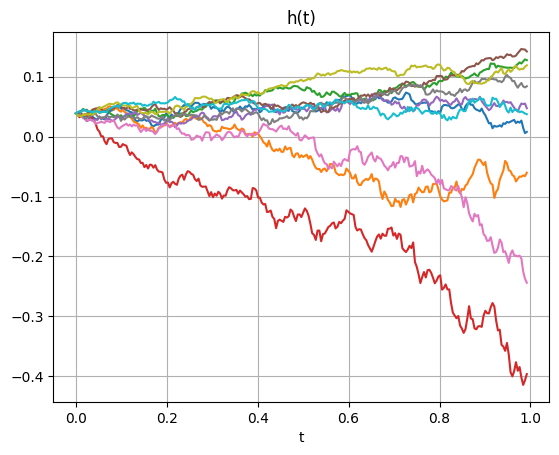

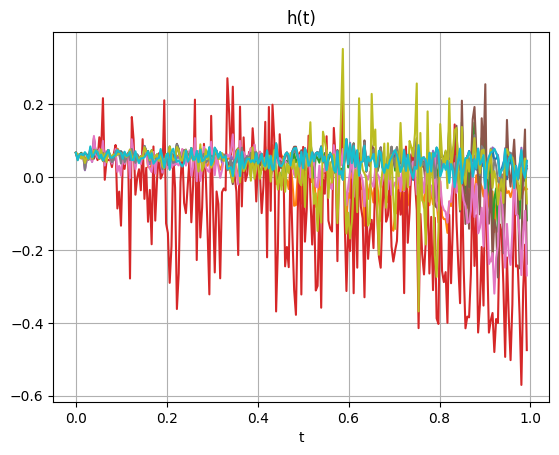

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# ==========================
# PARAMETROS GERAIS
# ==========================

np.random.seed(0)

M     = 1000      # nº de paths
K     = 150.0
S0    = 100.0     # moneyness S0/K = 1
T     = 1.0
t0    = 0.0
dt    = 0.05
mu    = 0.05
sigma = 0.2

sim = GBMSimulator(
        S0=S0,
        mu=mu,
        sigma=sigma,
        K=K,
        t0=t0,
        T=T,
        M=M
    )

S = sim.simulate_S()
H, dH_dS, d2H_dSS, dH_dt, d2H_dt_dS, d3H_dS3 = sim.simulate_H()
h0 = sim.init_control()
#L = sim.forward_PL(h0)
#LT = L[:,-1]
#risk = sim.risk_function(LT, risk_type='entw', gamma=1, k=2)
#pT = sim.terminal_adjoint(LT, risk_type='entw', gamma=1, k=2)
#pT = sim.terminal_adjoint(LT, risk_type='esl', beta=0.95)
#p, q = sim.backward_adjoint(pT, p_x = 1, lam_ridge=1e-4, lam_time=1e-4)
#G = sim.compute_gradient(p, q)
#h_updated = sim.update_control(h=h0, G=G)
# parâmetros da medida de risco
#risk_type = "entw"
#risk_kwargs = {"gamma": 1.0, "k": 2,}
risk_type = "esl"
risk_kwargs = {"beta": 0.95}

# otimização do hedge
h_opt, history = sim.optimize_hedge(
    risk_type=risk_type,
    risk_kwargs=risk_kwargs,
    max_iter=20,
    tol=1e-4,
    alpha=1e-2,
    verbose=True,
)

t = sim.t0 + sim.dt * np.arange(sim.steps)

# helper simples (ajustado)
def plot_df(arr, title, t=t):
    tt = t[:arr.shape[1]]              # arr é (M, K) -> usa K tempos
    df = pd.DataFrame(arr.T, index=tt)
    df.iloc[:, :10].plot(legend=False)
    plt.title(title)
    plt.xlabel("t")
    plt.grid(True)


# ----------------------------
# Plots (1 figura por objeto)
# ----------------------------
#plot_df(S, "S(t)")
#plot_df(H, "H(t,S)")
#plot_df(dH_dS, "Delta dH/dS")
#plot_df(d2H_dSS, "Gamma d²H/dS²")
#plot_df(d3H_dS3, "Third derivative d³H/dS³")
#plot_df(dH_dt, "Time derivative dH/dt")
#plot_df(d2H_dt_dS, "Mixed derivative d²H/(dt dS)")
#plot_df(L, "L(t)")
#plot_df(p, "p(t)")
#plot_df(q, "q(t)")
plot_df(h0, "h(t)")
plot_df(h_opt, "h(t)")
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# ==========================
# PARAMETROS GERAIS
# ==========================

np.random.seed(0)

M     = 1000      # nº de paths
K     = 100.0
S0    = 100.0     # moneyness S0/K = 1
T     = 1.0
t0    = 0.0
dt    = 0.05
mu    = 0.05
sigma = 0.2

# Heston
kappa   = 2.0
theta   = 0.04
sigma_v = 0.5
rho     = -0.5
v0      = 0.04

# Jump Diffusion (Merton)
lam = 1.0
mJ  = -0.05
sJ  = 0.1

# Medidas de risco e parâmetros
risk_specs = [
    ("ele",  {"a": 0.05}),
    ("elw",  {"k": 2.0}),
    ("entl", {"gamma": 0.5}),
    ("ente", {"gamma": 0.5, "a": 0.05}),
    ("entw", {"gamma": 0.5, "k": 2.0, "scale": 20.0}),
    ("es",   {"beta": 0.95}),
]

max_iter = 20
tol      = 1e-4
alpha    = 1e-3
verbose  = False

# ==========================
# FIGURE OUTPUT FOLDER
# ==========================

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# ==========================
# FACTORIES DOS MODELOS
# ==========================

def make_gbm():
    return GBMSimulator(
        M=M,
        S0=S0,
        K=K,
        mu=mu,
        sigma=sigma,
        t0=t0,
        T=T,
    )

def make_heston():
    return HestonSimulator(
        M=M,
        S0=S0,
        K=K,
        mu=mu,
        sigma=sigma,
        t0=t0,
        T=T,
        kappa=kappa,
        theta=theta,
        sigma_v=sigma_v,
        rho=rho,
        v0=v0,
    )

def make_jump():
    return JumpDiffusionSimulator(
        M=M,
        S0=S0,
        K=K,
        mu=mu,
        sigma=sigma,
        t0=t0,
        T=T,
        lam=lam,
        mJ=mJ,
        sJ=sJ,
    )

models = {
    "GBM": make_gbm,
    "Heston": make_heston,
    "Jump": make_jump,
}

# ==========================
# CONTÊINERS PARA RESULTADOS
# ==========================

S_paths     = {}
H_paths     = {}
t_grids     = {}
Eh_curves   = {}           # Eh_curves[modelo][risk_type] = E[h](t)
LT_samples  = {}           # LT_samples[modelo][risk_type] = L_T paths
risk_rows   = []           # para tabela final

# ==========================
# LOOP PRINCIPAL
# ==========================

for model_name, factory in models.items():
    print(f"modelo: {model_name}")
    sim = factory()

    # 1) S e H (uma vez por modelo)
    S_path = sim.simulate_S()
    sim.simulate_H()

    M_paths, N_time = S_path.shape
    t_grid = np.linspace(sim.t0, sim.T, N_time)

    S_paths[model_name] = S_path
    H_paths[model_name] = sim.H
    t_grids[model_name] = t_grid
    Eh_curves[model_name] = {}
    LT_samples[model_name] = {}

    # 2) loop sobre medidas de risco
    for risk_type, risk_kwargs in risk_specs:
        print(f"  medida: {risk_type}")
        h_star, history = sim.optimize_hedge(
            risk_type=risk_type,
            risk_kwargs=risk_kwargs,
            max_iter=max_iter,
            tol=tol,
            alpha=alpha,
            verbose=verbose,
        )

        # E[h](t)
        Eh = h_star.mean(axis=0)   # (N_time-1,)
        Eh_curves[model_name][risk_type] = Eh

        # P&L
        L = sim.forward_PL(h_star, L0=0.0)
        LT = L[:, -1]
        LT_samples[model_name][risk_type] = LT

        # risco no instante final
        rho_LT = sim.risk_function(LT, risk_type, **risk_kwargs)
        risk_rows.append({
            "Modelo": model_name,
            "Medida": risk_type,
            "rho(L_T)": rho_LT,
        })

# ==========================
# GRÁFICOS S (3 gráficos, com legendas)
# ==========================

for model_name in ["GBM", "Heston", "Jump"]:
    S_path = S_paths[model_name]
    t_grid = t_grids[model_name]

    plt.figure()
    n_show = min(30, S_path.shape[0])

    if model_name == "GBM":
        label_S = "Sample simulated underlying path (GBM)"
    elif model_name == "Heston":
        label_S = "Sample simulated underlying path (Heston)"
    else:
        label_S = "Sample simulated underlying path (Jump diffusion)"

    # primeira curva com label para legenda
    plt.plot(t_grid, S_path[0, :], linewidth=0.7, label=label_S)
    for m in range(1, n_show):
        plt.plot(t_grid, S_path[m, :], linewidth=0.7)

    plt.xlabel("Time")
    plt.ylabel("Underlying price")
    plt.title(f"Simulated underlying price paths ({model_name})")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"simulated_underlying_{model_name}.png"), dpi=300)
    plt.close()

# ==========================
# GRÁFICOS H (3 gráficos, com legendas)
# ==========================

for model_name in ["GBM", "Heston", "Jump"]:
    H = H_paths[model_name]
    t_grid = t_grids[model_name]

    plt.figure()
    n_show = min(30, H.shape[0])

    if model_name == "GBM":
        label_H = "Sample simulated contingent claim path (GBM)"
    elif model_name == "Heston":
        label_H = "Sample simulated contingent claim path (Heston)"
    else:
        label_H = "Sample simulated contingent claim path (Jump diffusion)"

    plt.plot(t_grid, H[0, :], linewidth=0.7, label=label_H)
    for m in range(1, n_show):
        plt.plot(t_grid, H[m, :], linewidth=0.7)

    plt.xlabel("Time")
    plt.ylabel("Contingent claim value")
    plt.title(f"Simulated contingent claim price paths ({model_name})")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"simulated_contingent_{model_name}.png"), dpi=300)
    plt.close()

# ==========================
# GRÁFICOS E[h] (3 gráficos, 6 curvas cada)
# ==========================

# legend labels a bit clearer but still short
risk_legend_labels = {
    "ele":  "ELE",
    "elw":  "ELW",
    "entl": "ENTL",
    "ente": "ENTE",
    "entw": "ENTW",
    "es":   "ES",
}

for model_name in ["GBM", "Heston", "Jump"]:
    t_grid = t_grids[model_name]
    plt.figure()
    for risk_type, _ in risk_specs:
        Eh = Eh_curves[model_name][risk_type]
        label = risk_legend_labels.get(risk_type, risk_type)
        plt.plot(t_grid[:-1], Eh, linewidth=0.9, label=label)
    plt.xlabel("Time")
    plt.ylabel("Average hedge ratio")
    plt.title(f"Average hedge ratio over time ({model_name})")
    plt.legend(fontsize=7)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"average_hedge_{model_name}.png"), dpi=300)
    plt.close()

# ==========================
# HISTOGRAMAS L_T (18 subplots numa figura, com títulos)
# ==========================

n_models = len(models)
n_risks  = len(risk_specs)

# calcular intervalo global de L_T para ajeitar os eixos
all_LT = []
for model_name in ["GBM", "Heston", "Jump"]:
    for risk_type, _ in risk_specs:
        all_LT.append(LT_samples[model_name][risk_type])
all_LT = np.concatenate(all_LT)
xmin, xmax = np.min(all_LT), np.max(all_LT)
dx = xmax - xmin if xmax > xmin else 1.0
xmin_plot = xmin - 0.05 * dx
xmax_plot = xmax + 0.05 * dx

fig, axes = plt.subplots(
    n_models, n_risks,
    figsize=(3 * n_risks, 2.5 * n_models),
    squeeze=False
)

for i, model_name in enumerate(["GBM", "Heston", "Jump"]):
    for j, (risk_type, _) in enumerate(risk_specs):
        ax = axes[i, j]
        LT = LT_samples[model_name][risk_type]
        ax.hist(LT, bins=30, density=True, edgecolor="black", linewidth=0.4)
        ax.set_xlim(xmin_plot, xmax_plot)
        ax.set_title(f"{model_name} - {risk_type}", fontsize=7)
        ax.tick_params(axis="x", labelsize=6)
        ax.tick_params(axis="y", labelsize=6)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "histograms_LT_all_models.png"), dpi=300)
plt.close()

# ==========================
# TABELA FINAL rho(L_T)
# ==========================

risk_table = pd.DataFrame(risk_rows)
print(risk_table.pivot(index="Modelo", columns="Medida", values="rho(L_T)"))


In [ ]:
# ==========================
# CONTAINERS FOR RESULTS
# ==========================

S_paths     = {}
H_paths     = {}
t_grids     = {}
Eh_curves   = {}           # Eh_curves[model][risk_type] = E[h](t)
LT_samples  = {}           # LT_samples[model][risk_type_opt] = L_T paths (under that optimized measure)
risk_rows   = []           # for the big final table


# ==========================
# MAIN LOOP
# ==========================

for model_name, factory in models.items():
    print(f"model: {model_name}")
    sim = factory()

    # 1) S and H (once per model)
    S_path = sim.simulate_S()
    sim.simulate_H()

    M_paths, N_time = S_path.shape
    t_grid = np.linspace(sim.t0, sim.T, N_time)

    S_paths[model_name] = S_path
    H_paths[model_name] = sim.H
    t_grids[model_name] = t_grid
    Eh_curves[model_name] = {}
    LT_samples[model_name] = {}

    # 2) loop over risk measures used in the optimization
    for risk_type_opt, risk_kwargs_opt in risk_specs:
        print(f"  optimized measure: {risk_type_opt}")
        h_star, history = sim.optimize_hedge(
            risk_type=risk_type_opt,
            risk_kwargs=risk_kwargs_opt,
            max_iter=max_iter,
            tol=tol,
            alpha=alpha,
            verbose=verbose,
        )

        # E[h](t) under this optimized strategy
        Eh = h_star.mean(axis=0)   # (N_time-1,)
        Eh_curves[model_name][risk_type_opt] = Eh

        # P&L under this optimized strategy
        L = sim.forward_PL(h_star, L0=0.0)
        LT = L[:, -1]
        LT_samples[model_name][risk_type_opt] = LT

        # 3) evaluate ALL risk measures on this same LT
        for risk_type_eval, risk_kwargs_eval_base in risk_specs:
            # use a copy of kwargs to avoid accidental mutation
            risk_kwargs_eval = risk_kwargs_eval_base.copy()
            rho_LT_eval = sim.risk_function(LT, risk_type_eval, **risk_kwargs_eval)
            risk_rows.append({
                "Model": model_name,
                "Optimized": risk_type_opt,
                "Evaluated": risk_type_eval,
                "rho(L_T)": rho_LT_eval,
            })


# ==========================
# BIG TABLE rho(L_T) FOR ALL COMBINATIONS
# ==========================

risk_table = pd.DataFrame(risk_rows)

# pivot so that rows = (Model, Optimized), columns = Evaluated measure
pivot_table = risk_table.pivot_table(
    index=["Model", "Optimized"],
    columns="Evaluated",
    values="rho(L_T)"
)

print(pivot_table)


In [ ]:
pivot_table